In [1]:
import sys; sys.path.insert(0, "..")
from multifunbrain import *
#
hello_brain("🧠 Giulio")

'Hello, 🧠 Giulio! Welcome to multifun-brain.'

In [2]:
def generate_brain_timeseries(n_regions, region_sizes, return_time=False, n_timepoints=1000,
                              return_labels=False, weight_distribution='powerlaw', alpha=2.5, seed=42):
    np.random.seed(seed)
    n_nodes = sum(region_sizes)
    # Assign each node to a region
    region_labels = np.concatenate([np.full(size, i) for i, size in enumerate(region_sizes)])
    
    # Initialize connectivity matrix (J) with zeros
    J = np.zeros((n_nodes, n_nodes))
    
    # Define minimal weight (xmin) for powerlaw scaling
    xmin = 0.1

    # Create connectivity for nodes within the same region
    idx_start = 0
    for size in region_sizes:
        idx_end = idx_start + size
        region_idx = np.arange(idx_start, idx_end)
        if weight_distribution == 'powerlaw':
            # Sample weights from a Pareto distribution.
            # The Pareto distribution (np.random.pareto) gives values in [0, inf) with pdf ~ (x+1)^(-alpha).
            # Shift and scale to get a powerlaw decay ~ w^(-alpha) for w >= xmin.
            weights = (np.random.pareto(alpha - 1, size=(size, size)) + 1) * xmin
        else:
            # Fallback: uniform distribution if distribution type not recognized.
            weights = np.random.uniform(0, xmin, size=(size, size))
        
        np.fill_diagonal(weights, 0)  # zero self-connections
        J[np.ix_(region_idx, region_idx)] = weights
        idx_start = idx_end

    # Set simulation parameters and initialize timeseries
    dt = 0.1
    ts = np.zeros((n_timepoints, n_nodes))
    ts[0, :] = np.random.normal(0, 1, n_nodes)  # initial condition

    # Euler integration for dx/dt = -x + J @ x
    for t in range(1, n_timepoints):
        x_prev = ts[t - 1, :]
        x_dot = -x_prev + np.dot(J, x_prev)
        ts[t, :] = x_prev + dt * x_dot

    time_array = np.arange(0, n_timepoints * dt, dt)
    
    if return_time and return_labels:
        return ts, time_array, region_labels
    elif return_time:
        return ts, time_array
    elif return_labels:
        return ts, region_labels
    else:
        return ts

In [20]:
n_regions = 3
region_sizes = [33, 33, 34]  # Total nodes = 100
ts, t, region_labels = generate_brain_timeseries(n_regions=n_regions,
                                                    region_sizes=region_sizes,
                                                    return_time=True,
                                                    n_timepoints=80,
                                                    return_labels=True,
                                                    weight_distribution='powerlaw',
                                                    alpha=2.5,
                                                    seed=42)

In [21]:
C = np.corrcoef(ts.T)  # Check correlation matrix
np.fill_diagonal(C, 0)  # Remove self-correlation
G = nx.from_numpy_array(C)

In [ ]:
np.max(np.real(np.linalg.eigvals(J)))

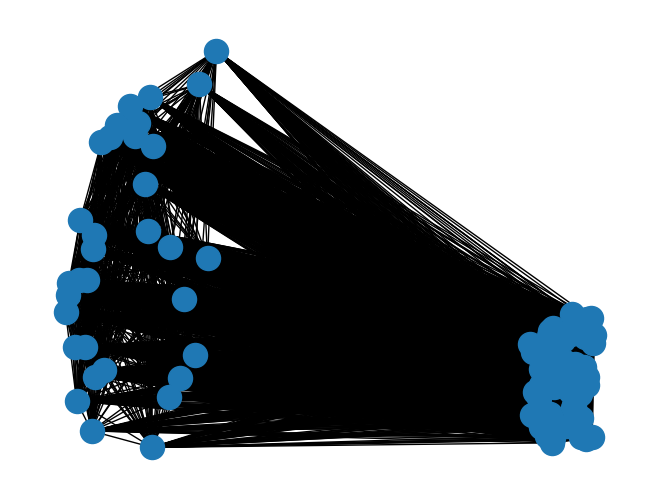

In [22]:
nx.draw(G)

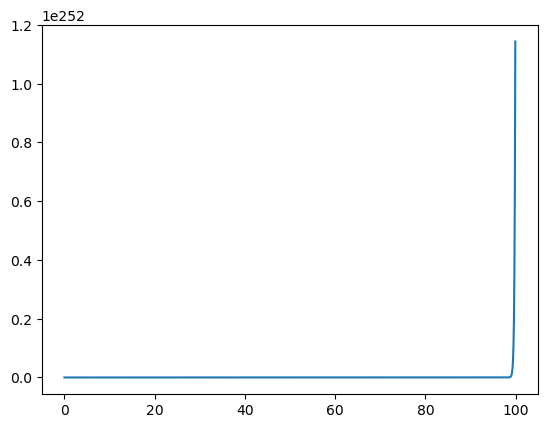

In [4]:
plt.plot(t, ts[:, 0], label='Region 0')

Nodes: 192, Edges: 896


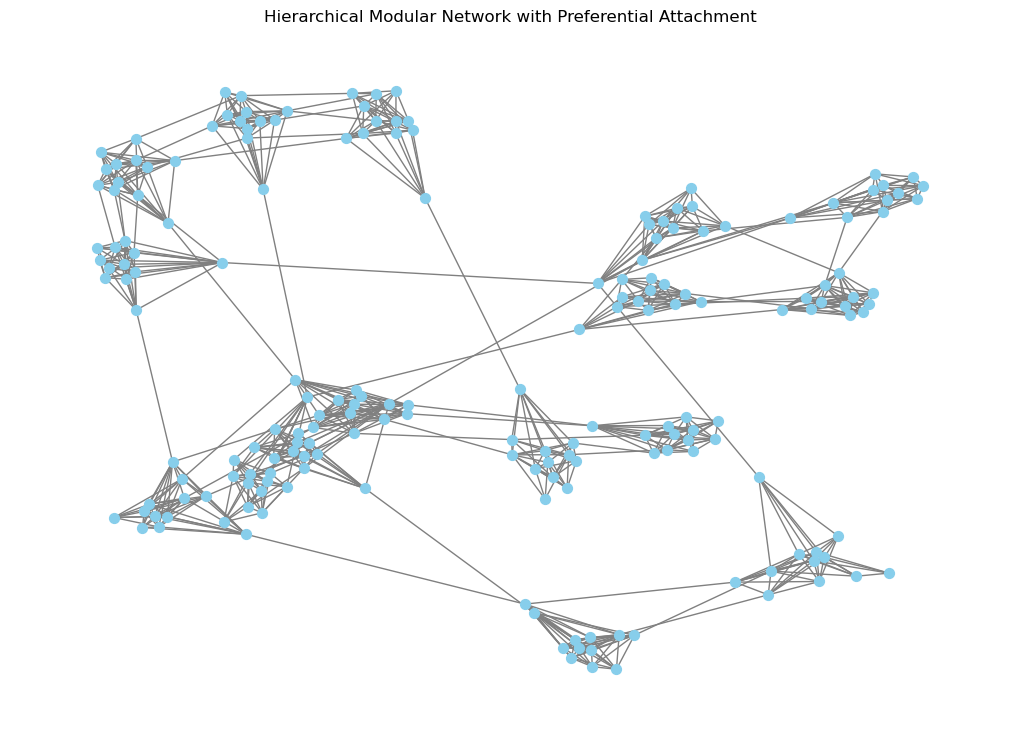

In [ ]:
G = generate_hierarchical_modular_pa(
    base_module_size=12,
    levels=4,             # 2^4 = 16 base modules → ~192 nodes
    intra_p=0.8,
    inter_edges=3,
    seed=42
)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_color="skyblue", edge_color="gray", node_size=50, with_labels=False)
plt.title("Hierarchical Modular Network with Preferential Attachment")
plt.show()

In [3]:
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
tau = 50

In [4]:
num = expm(-tau * L)
den = np.trace(num)
rho = num / den
Trho = 1.0 / rho
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)

In [5]:
Sm1, Csp, VarL, t = entropy(spectrum, steps=600, t1=-2, t2=5)

/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/core.py:216: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/core.py:216: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


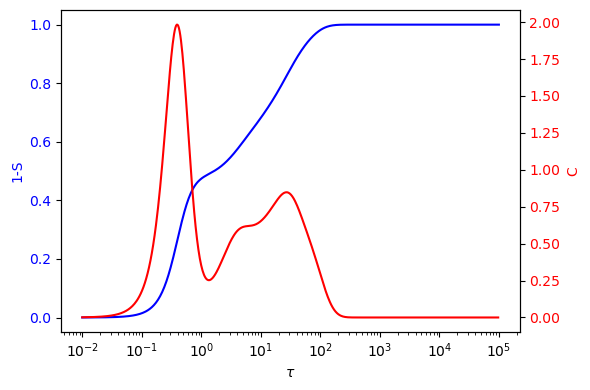

In [6]:
color1 = "blue"
color2 = "red"

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(t, Sm1, label=r"$1-S$", color=color1)
ax1.set_ylabel("1-S", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')

ax2 = ax1.twinx()
ax2.plot(t[:-1], Csp, label=r"$C$", color=color2)
ax2.set_ylabel("C", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_xlabel(r"$\tau$")
fig.tight_layout()


In [7]:
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')

In [8]:
threshold = 4e-1
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

(np.float64(0.05188951901842301), np.float64(1.0396039603960399))

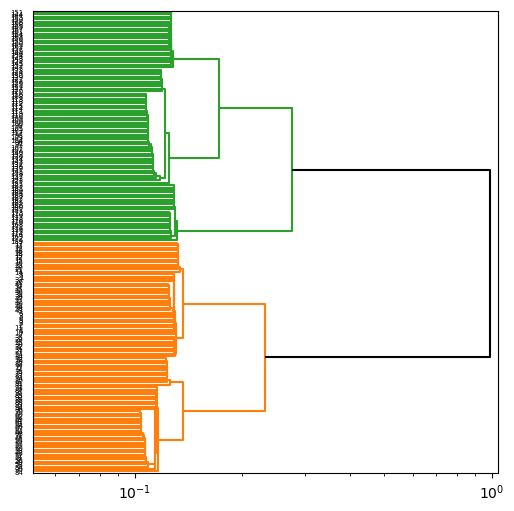

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
#
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
dendro = dendrogram(linkage_matrix, ax=ax, 
                    color_threshold=threshold,
                    above_threshold_color='k',
                    orientation='right')
ax.set_xscale('log')
ax.set_xlim(tmin)

In [10]:
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[str(label)] for label in label_list]

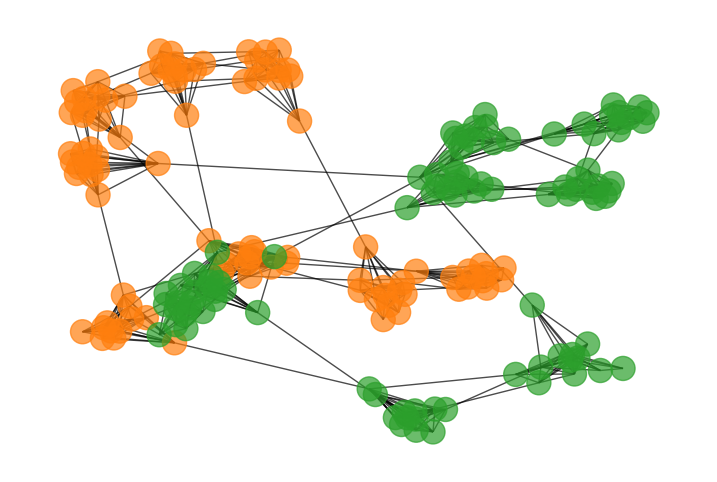

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
nx.draw(G, pos=pos, ax=ax, node_color=node_colors,  alpha=0.7)

### Flowergraph

In [ ]:
G = generate_flower_graph(u=2, v=2, iterations=5)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=40, edge_color="gray")
plt.title("(2,2)-Flower Graph")
plt.show()


### test

In [ ]:
n_regions = 3
region_sizes = 10
number_of_nodes = region_sizes*n_regions

In [ ]:
ts, t, region_labels = generate_brain_timeseries_4(n_regions=n_regions, region_sizes=region_sizes, return_time=True, n_timepoints=1000, return_labels=True, weight_distribution='powerlaw', alpha=2.5, seed=42)
node_to_region_map = dict(zip(list(range(number_of_nodes)), region_labels))

In [ ]:
for i in range(10):
    plt.plot(ts[i])

plt.xlim(800, 1000)

In [ ]:
corr = compute_correlation_matrix(ts)
corr = corr - np.diag(np.diag(corr))  # Remove diagonal for visualization
corr[corr < 0] = 0  # Set negative correlations to zero
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Functional Connectivity (Correlation Matrix)")
plt.xlabel("Region")
plt.ylabel("Region")
plt.show()

In [ ]:
G = nx.from_numpy_array(corr)
Th, Einf, Pinf = compute_threshold_stats(G)
plt.plot(Th, Pinf)
plt.plot(Th, Einf)

In [ ]:
best_th = 0.001

In [ ]:
C_th = corr.copy()
C_th[corr < best_th] = 0
G0 = nx.from_numpy_array(C_th)
G0 = get_giant_component(G0)

In [ ]:
L = nx.laplacian_matrix(G0).todense()
spectrum = nx.laplacian_spectrum(G0)
#
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(G0, with_labels=True, alpha=0.7)

In [ ]:
def rho_matrix(tau):
    num = expm(-tau * L)
    den = np.trace(num)
    return num / den
Sm1, Csp, VarL, t = entropy(spectrum, steps=600, t1=-2, t2=5)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 4))
#
color1 = "blue"
color2 = "red"
#
ax1.plot(t, Sm1, label=r"$1-S$", color=color1)
ax1.set_ylabel("1-S", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')
ax2 = ax1.twinx()
ax2.plot(t[:-1], Csp, label=r"$C$", color=color2)
ax2.set_ylabel("C", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_xlabel(r"$\tau$")
#
fig.tight_layout()

In [ ]:
Trho = 1.0 / rho_matrix(tau)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
#
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G0, method='ward')
threshold = 0.0001
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
#
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
dendro = dendrogram(linkage_matrix, ax=ax[0], 
                    color_threshold=threshold,
                    above_threshold_color='k',
                    orientation='right')
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[str(label)] for label,_ in enumerate(label_list)]
ax[0].set_xscale('log')
ax[0].set_xlim(tmin)
nx.draw(G0, ax=ax[1], node_color=node_colors, alpha=0.7)